In [1]:
import pandas as pd
import numpy as np
import glob

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('./local/features.csv')
df.head()

,track_id,title,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0aQA9DP54h37OevE7hRc2a,My Stress,NF,0.653,0.796,7,-4.050,0,0.2450,0.2400,0.00000,0.1080,0.405,160.026,252712,4
1,4ixBAI0E1M6df9mP27etZK,Korter,Emmsjé Gauti,0.731,0.494,4,-9.567,1,0.0467,0.2010,0.00000,0.1600,0.477,120.045,228056,4
2,3jO5IAvslWxaTxswokg66i,CU U U U UX,Feid,0.859,0.464,3,-7.328,1,0.2890,0.2080,0.00000,0.1140,0.370,134.966,195453,4
3,5iS3TEmmRcDJU2pTJQ98zB,Mustarastaan laulu viemärissä,Pyhimys,0.482,0.617,10,-10.288,0,0.0869,0.7750,0.58300,0.1070,0.350,174.040,300861,4
4,29xPIFa0othUcFrEGyJCZu,Prototype,RK,0.824,0.684,1,-7.185,1,0.4070,0.0236,0.00853,0.0762,0.509,141.143,186973,4


In [3]:
df.shape

(54775, 16)

In [4]:
# Max number of tracks take into account
n_total = len(glob.glob('./local/scraped_data/*/*'))*200
print(n_total)

1985400


**Wstępnie można zaobserwować występowanie tych samych utworów w ramach wielu rankingów.**

In [5]:
n_ranks = {}
country_codes = [path.split('/')[-1] for path in glob.glob('./local/scraped_data/*')]
for country_code in country_codes:
    n_ranks[country_code] = len(glob.glob(f'./local/scraped_data/{country_code}/*'))
    
n_ranks = sorted(n_ranks.items(), key=lambda x: x[1])
n_ranks = dict(n_ranks)

In [6]:
n_ranks

{'by': 3,
 'in': 158,
 'ae': 172,
 'eg': 172,
 'il': 208,
 'ch': 271,
 'ie': 271,
 'fr': 271,
 'cy': 271,
 'au': 271,
 'es': 271,
 'br': 271,
 'at': 271,
 'be': 271,
 'ec': 271,
 'de': 271,
 'hk': 271,
 'gb': 271,
 'co': 271,
 'gr': 271,
 'bg': 271,
 'ca': 271,
 'us': 271,
 'cz': 271,
 'cl': 271,
 'id': 271,
 'bo': 271,
 'hn': 271,
 'it': 271,
 'global': 271,
 'ee': 271,
 'do': 271,
 'cr': 271,
 'hu': 271,
 'ar': 271,
 'gt': 271,
 'dk': 271,
 'is': 271,
 'fi': 271}

**Informacje o rankingach są niepełne dla takich państw jak Białoruś (3), Indie (158), Emiraty Arabskie (172), Egipt (172) oraz Izrael (208).**

In [7]:
drop_cols = ['track_id', 'title', 'artist', 'key', 'mode', 'time_signature']
df_numeric = df.drop(drop_cols, axis=1)
features = list(df_numeric.columns)
x = df_numeric.to_numpy()
x = StandardScaler().fit_transform(x)

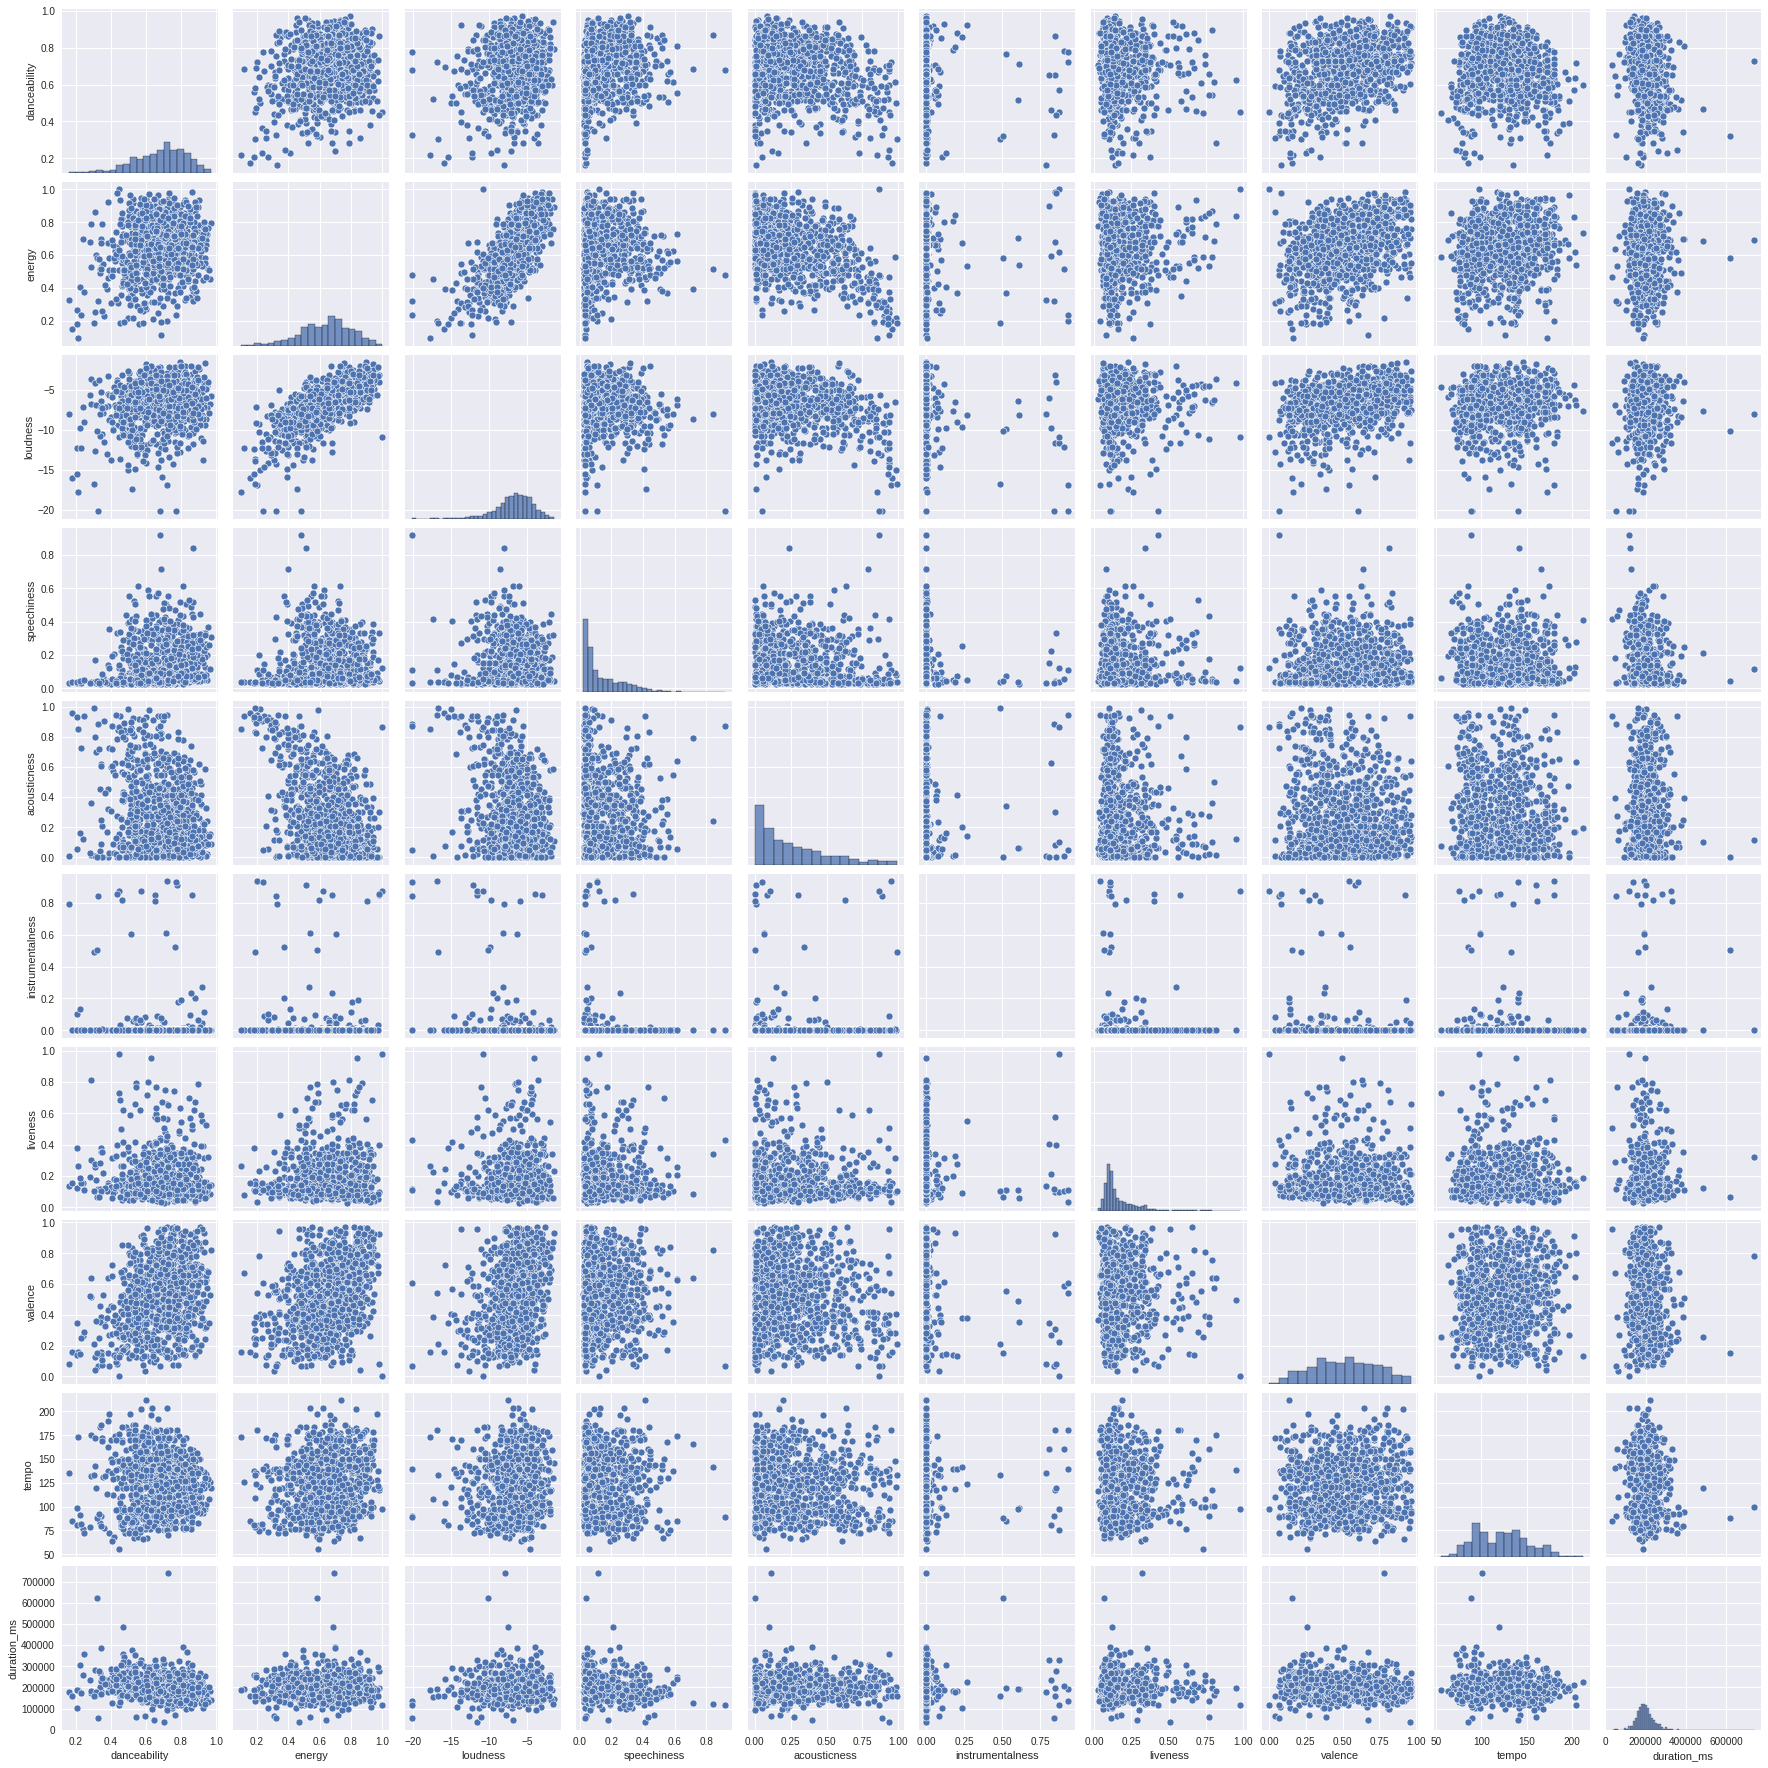

In [8]:
sns.pairplot(df.sample(n=1000).drop(drop_cols, axis=1));

**Cechy audio nie są skorelowane (zauważalna korelacja jedynie dla `energy` i `loudness`), charakteryzują się różnymi rozkładami.**

In [9]:
pca = PCA()
x_pca = pca.fit_transform(x)

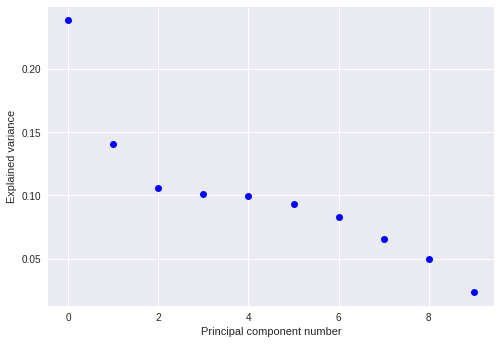

In [10]:
plt.plot(pca.explained_variance_ratio_, 'bo')
plt.xlabel('Principal component number')
plt.ylabel('Explained variance')
plt.show()

**Poszczególne komponenty zachowują względnie dużo informacji - zbiór jest złożony.**

In [11]:
pc1 = pca.components_[0]
pc2 = pca.components_[1]
print('Attribute, PC1, PC2')

projected_features = {}

for i in range(0, pc1.shape[0]):
    print(features[i] + ' : ' + repr(pc1[i]) + ' : ' + repr(pc2[i]))
    projected_features[features[i]] = (pc1[i], pc2[i])

Attribute, PC1, PC2
danceability : -0.2677376858999837 : -0.55327165124674
energy : -0.5537467710514777 : 0.22992532585461262
loudness : -0.5180402570431675 : 0.2464321968844966
speechiness : -0.05740324398898783 : -0.46732727149121517
acousticness : 0.4085035901970685 : -0.059917387829174634
instrumentalness : 0.15214885237201922 : 0.07859439267575177
liveness : -0.09774691178109476 : 0.23734669716731222
valence : -0.3678759864168158 : -0.20607861881203035
tempo : -0.07910080417951677 : 0.0851980530957375
duration_ms : 0.09408300012447925 : 0.49605794636640954


**Wartości elementów są stosunkowo duże dla wszystkich cech, oprócz cechy `tempo`.**

In [12]:
# Scale component values down for clarity
x_pca[:, 0] /= np.amax(x_pca[:, 0])
x_pca[:, 1] /= np.amax(x_pca[:, 1])

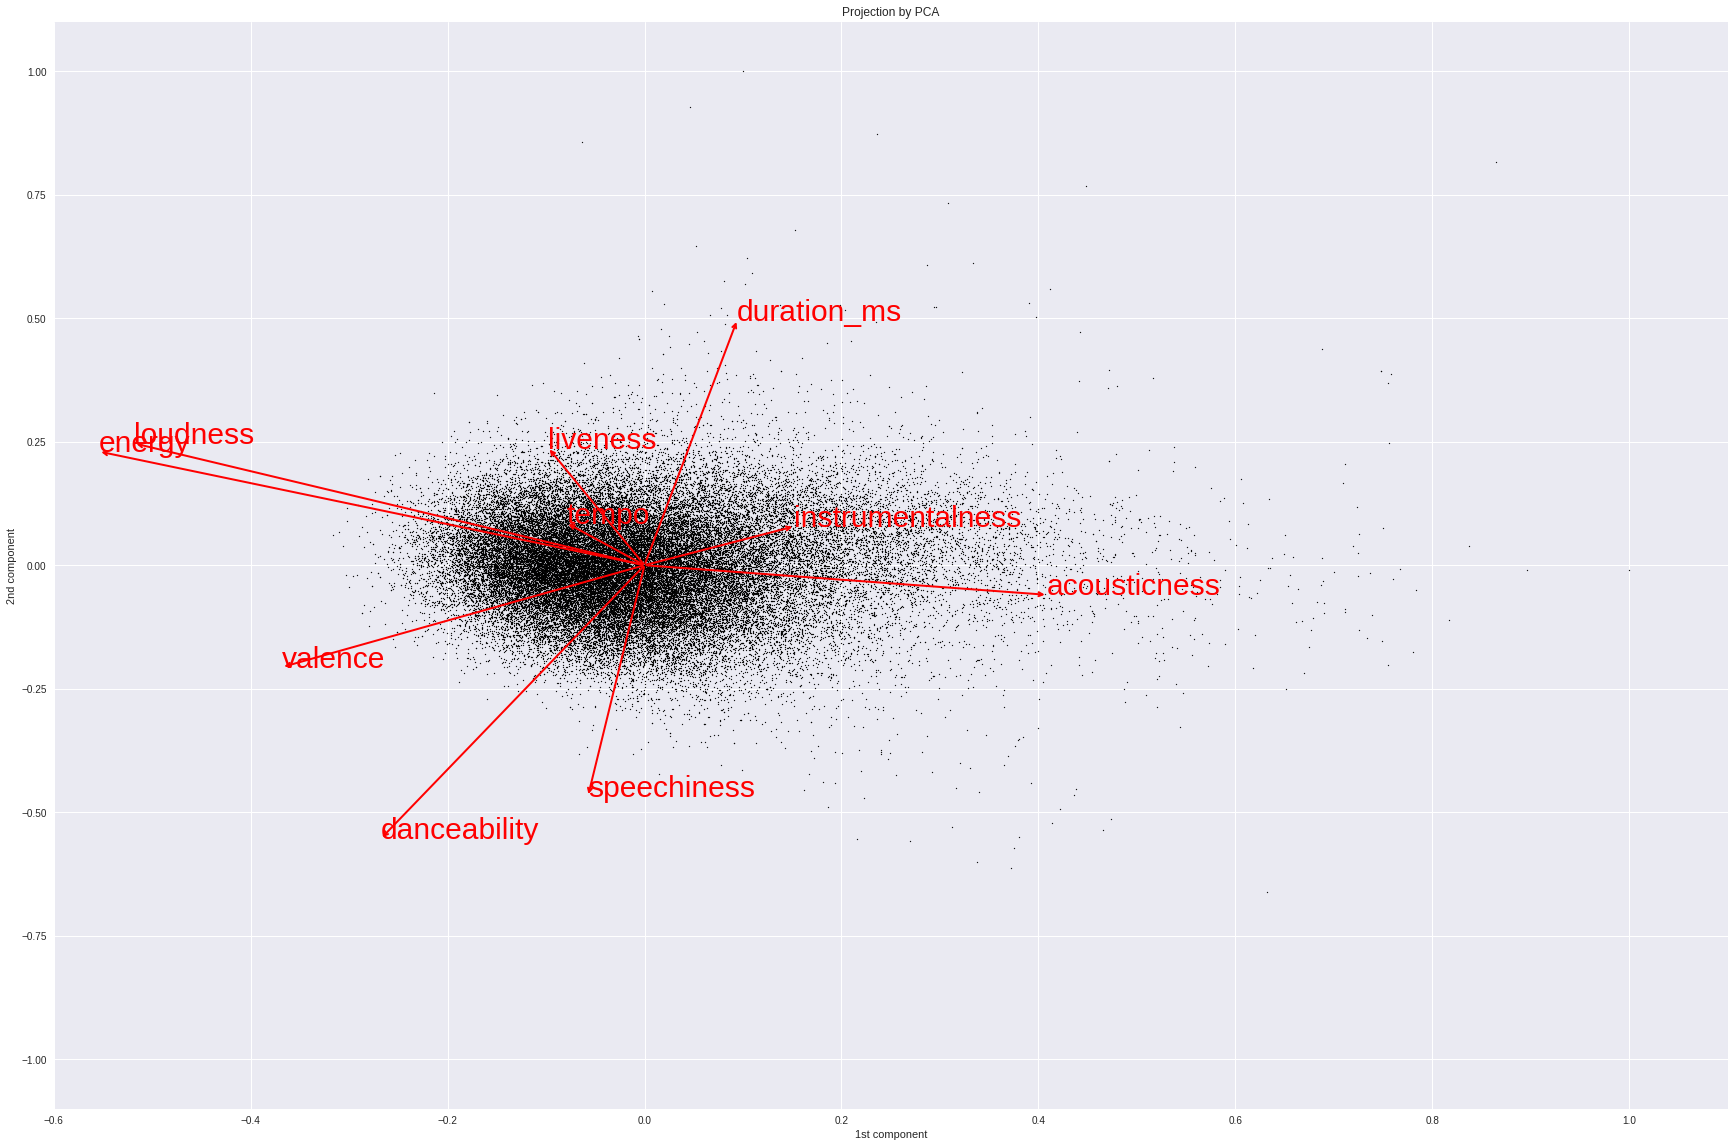

In [13]:
plt.figure(figsize=(30, 20))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c='k', s=1)

for feature_name, coords in projected_features.items():
    plt.annotate('', xy=coords, xytext=(0, 0), arrowprops=dict(arrowstyle='->', color='r', lw=2))
    plt.text(x=coords[0], y=coords[1], text=feature_name, s=30, fontsize=30, color='r')

plt.title('Projection by PCA')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.ylim(-1.1, 1.1)
plt.xlim(-0.6, 1.1)
plt.show()

**Przestrzeń jest rozciągana głównie przez to, jak utwory są głośne i energiczne oraz jak bardzo są akustyczne.**